<img src="https://i2.wp.com/www.ai-claudio.com/wp-content/uploads/2017/05/keras-tensorflow-logo.jpg?resize=500%2C201"/>

## Import modules 


In [235]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
from keras.models import Sequential
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal, RandomUniform
from keras import regularizers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.constraints import max_norm
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

## Keras Model Parameters

In [236]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 100       # Training batch size
train_size  = 100000     # Training size
valid_size  = 10000     # Validation size
test_size   = 10000      # Test size
epochs      = 20       # Number of epochs
doGPU       = False    # Use GPU

In [237]:
if doGPU:
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.Session(config=config))

## Load Image Data
### Two classes of particles: electrons and photons 
### Images from 32x32 matrices of energies in each calorimeter cell (one cell = one pixel) 

In [238]:
img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

## Configure Training/Validation/Test Sets

In [239]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

## Plot  sample of training images

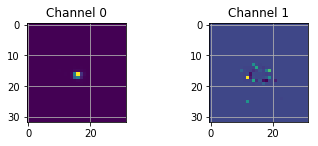

In [240]:
plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[1,:,:,0])
plt.title("Channel 0")  # Energy
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1,:,:,1])
plt.title("Channel 1")  # Time
plt.grid(True)


plt.show()

## Define CNN Model

In [241]:
### Define CNN Model ###

model = Sequential()
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal', input_shape=(img_rows, img_cols, nb_channels)))
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_constraint=max_norm(2.), kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu',kernel_constraint=max_norm(2.), kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_105 (Conv2D)          (None, 32, 32, 16)        304       
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 8, 8, 32)          0         
__________

### Train the Model

In [242]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

Train on 200000 samples, validate on 20000 samples
Epoch 1/20
200000/200000 [==============================] - 743s 4ms/step - loss: 0.6468 - acc: 0.6264 - val_loss: 0.6098 - val_acc: 0.6737
Epoch 2/20
200000/200000 [==============================] - 716s 4ms/step - loss: 0.6107 - acc: 0.6782 - val_loss: 0.5935 - val_acc: 0.6911
Epoch 3/20
200000/200000 [==============================] - 742s 4ms/step - loss: 0.5955 - acc: 0.6916 - val_loss: 0.5808 - val_acc: 0.7037
Epoch 4/20
200000/200000 [==============================] - 737s 4ms/step - loss: 0.5890 - acc: 0.6982 - val_loss: 0.5746 - val_acc: 0.7029
Epoch 5/20
200000/200000 [==============================] - 735s 4ms/step - loss: 0.5845 - acc: 0.7019 - val_loss: 0.5701 - val_acc: 0.7106
Epoch 6/20
200000/200000 [==============================] - 739s 4ms/step - loss: 0.5811 - acc: 0.7041 - val_loss: 0.5726 - val_acc: 0.7074
Epoch 7/20
200000/200000 [==============================] - 696s 3ms/step - loss: 0.5784 - acc: 0.7055 - val_

### Evaluate The Model

In [243]:
# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

20000/20000 [==============================] - 20s 1ms/step

Validation loss / accuracy: 0.5456 / 0.7282
('Validation ROC AUC:', 0.79811954500000015)
20000/20000 [==============================] - 19s 963us/step

Test loss / accuracy: 0.5557 / 0.7205
('Test ROC AUC:', 0.78880235500000007)


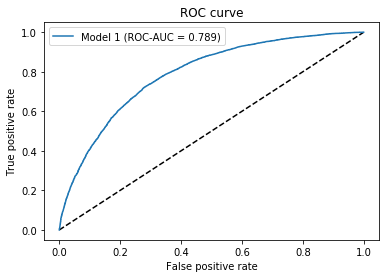

In [244]:
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()